In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 인공 신경망 모델을 설계할 때 필요한 함수를 모아 둔 모듈
import torch.nn as nn

# nn에서 자주 이용되는 함수를 F로 지정
import torch.nn.functional as F

# computer vision에서 자주 이용되는 torchvision 모듈 내 transforms, datasets함수
from torchvision import transforms, datasets

In [9]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else :
  DEVICE = torch.device('cpu')

print('torch version : ', torch.__version__)
print('torch device : ', DEVICE)

torch version :  1.10.0+cu111
torch device :  cuda


In [10]:
# 파이썬 코드 내 하이퍼파라미터를 지정할 땐 보통 영어 대문자를 사용한다.
BATCH_SIZE = 32
EPOCHS = 10

FashionMNIST 특징(feature)은 PIL Image 형식이며, 정답(label)은 정수(integer)입니다. 학습을 하려면 정규화(normalize)된 텐서 형태의 특징(feature)과 원-핫(one-hot)으로 부호화(encode)된 텐서 형태의 정답(label)이 필요합니다. 이러한 변형(transformation)을 하기 위해 ToTensor 와 Lambda 를 사용합니다.
- ToTensor()
ToTensor 는 PIL Image나 NumPy ndarray 를 FloatTensor 로 변환하고, 이미지의 픽셀의 크기(intensity) 값을 [0., 1.] 범위로 비례하여 조정(scale)합니다.

- Lambda 변형(Transform)
Lambda 변형은 사용자 정의 람다(lambda) 함수를 적용합니다. 여기에서는 정수를 원-핫으로 부호화된 텐서로 바꾸는 함수를 정의합니다. 이 함수는 먼저 (데이터셋 정답의 개수인) 크기 10짜리 영 텐서(zero tensor)를 만들고, scatter_ 를 호출하여 주어진 정답 y 에 해당하는 인덱스에 value=1 을 할당합니다.
```python
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
```

In [33]:
# train=True or False : MLP모델의 학습용 데이터인지 검증용 데이터인지를 나눈다.
train_dataset = datasets.MNIST(root = './', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./', train=False, transform=transforms.ToTensor())

# 미니배치 개수로 데이터를 묶어서 저장해둔다.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
for (X_train, y_train) in train_loader:
  print('X_train : ', X_train.size(), 'type : ', X_train.type())
  print('y_train : ', y_train.size(), 'type : ', y_train.type())
  break

X_train :  torch.Size([32, 1, 28, 28]) type :  torch.FloatTensor
y_train :  torch.Size([32]) type :  torch.LongTensor


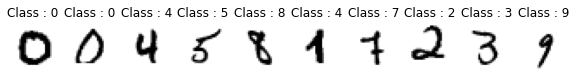

In [37]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
  plt.title('Class : '+str(y_train[i].item()))

In [41]:
# MLP 모델 생성
class Net(nn.Module):
  # nn.Module을 상속받아서 nn.Module내에 있는 함수를 그대로 쓰자.
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
  
  def forward(self, x):
    # view함수를 통해 Flatten을 해주자. view는 reshape와 비슷하지만 original data가 변경되면 같이 변경되게 된다.
    x = x.view(-1, 28*28)
    x = self.fc1(x)
    x = F.sigmoid(x)
    x = self.fc2(x)
    x = F.sigmoid(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    return x

In [43]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [45]:
# torch.optim이 지원하는 optimizer들
# 'ASGD', 'Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'LBFGS', 'NAdam', 
# 'Optimizer', 'RAdam', 'RMSprop', 'Rprop', 'SGD', 'SparseAdam'

In [46]:
# MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch : {} [{}/{} ( {:.0f}%)]\t Train Loss : {:.6f}'.format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100. * batch_idx/len(train_loader), loss.item()))

In [48]:
# 모델 검증 성능 확인 함수
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [49]:
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print('\n[EPOCH : {}], \t Test Loss: {:.4f}, \tTest Accuracy : {:.2f} %\n'.format(Epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch : 1 [0/60000 ( 0%)]	 Train Loss : 2.331361
Train Epoch : 1 [6400/60000 ( 11%)]	 Train Loss : 2.343015
Train Epoch : 1 [12800/60000 ( 21%)]	 Train Loss : 2.280530
Train Epoch : 1 [19200/60000 ( 32%)]	 Train Loss : 2.231835
Train Epoch : 1 [25600/60000 ( 43%)]	 Train Loss : 2.283447
Train Epoch : 1 [32000/60000 ( 53%)]	 Train Loss : 2.282241
Train Epoch : 1 [38400/60000 ( 64%)]	 Train Loss : 2.271087
Train Epoch : 1 [44800/60000 ( 75%)]	 Train Loss : 2.237365
Train Epoch : 1 [51200/60000 ( 85%)]	 Train Loss : 2.261948
Train Epoch : 1 [57600/60000 ( 96%)]	 Train Loss : 2.295702

[EPOCH : 1], 	 Test Loss: 0.0701, 	Test Accuracy : 9.58 %

Train Epoch : 2 [0/60000 ( 0%)]	 Train Loss : 2.165119
Train Epoch : 2 [6400/60000 ( 11%)]	 Train Loss : 2.177155
Train Epoch : 2 [12800/60000 ( 21%)]	 Train Loss : 2.203238
Train Epoch : 2 [19200/60000 ( 32%)]	 Train Loss : 2.123605
Train Epoch : 2 [25600/60000 ( 43%)]	 Train Loss : 2.013118
Train Epoch : 2 [32000/60000 ( 53%)]	 Train Loss : 1